
# California Housing – CLT, CI ir Hipotezių testavimas *(tikras sklearn duomenų rinkinys)*


Šiame „Notebook“ naudosime **tik `sklearn.datasets.fetch_california_housing`** duomenis:
- Greita apžvalga (EDA)
- 95% **pasikliautinis intervalas (CI)** `MedInc` vidurkiui
- **CLT** demonstracija: imčių vidurkių pasiskirstymas
- **t‑test** (Welch) tarp dviejų grupių
- **Chi²** testas (po sugrupavimo į kategorijas)


## 0. Aplinka ir paketai

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_california_housing

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True



## 1. Duomenų įkėlimas

In [3]:

housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()
print("Stulpeliai:", list(df.columns))
print("Forma:", df.shape)
df.head()


Stulpeliai: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
Forma: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Greita apžvalga (EDA)

In [4]:

df.describe().T


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


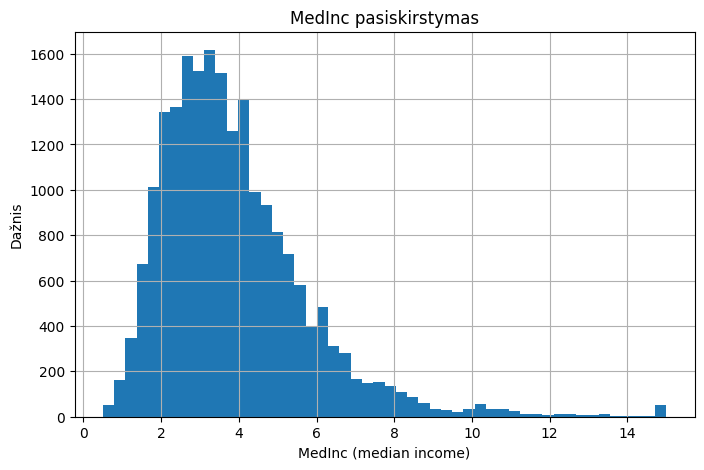

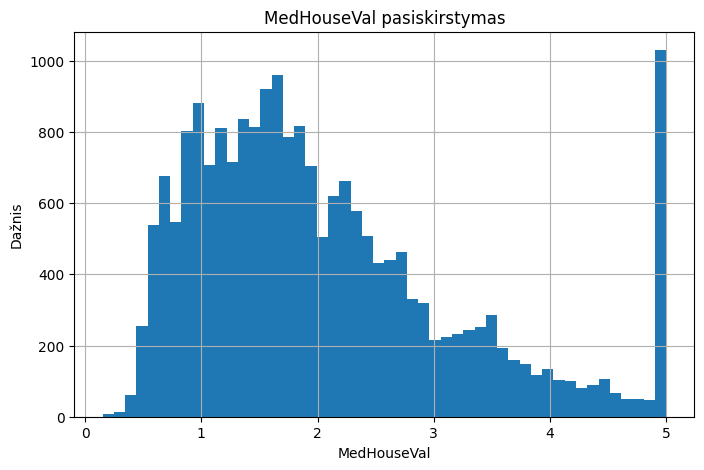

In [5]:

fig, ax = plt.subplots()
ax.hist(df["MedInc"], bins=50)
ax.set_title("MedInc pasiskirstymas")
ax.set_xlabel("MedInc (median income)"); ax.set_ylabel("Dažnis")
plt.show()

fig, ax = plt.subplots()
ax.hist(df["MedHouseVal"], bins=50)
ax.set_title("MedHouseVal pasiskirstymas")
ax.set_xlabel("MedHouseVal"); ax.set_ylabel("Dažnis")
plt.show()


## 3. 95% pasikliautinis intervalas (CI) `MedInc` vidurkiui

In [6]:

def ci_t_mean(x, alpha=0.05):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = x.size
    xbar = x.mean()
    s = x.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s / np.sqrt(n)
    return (xbar - half, xbar + half, xbar, s, n)

ci_lo, ci_hi, mean_medinc, s_medinc, n_medinc = ci_t_mean(df["MedInc"], alpha=0.05)
print(f"n = {n_medinc}")
print(f"Vidurkis = {mean_medinc:.6f}, s = {s_medinc:.6f}")
print(f"95% CI (t): [{ci_lo:.6f}, {ci_hi:.6f}]")


n = 20640
Vidurkis = 3.870671, s = 1.899822
95% CI (t): [3.844751, 3.896591]


## 4. CLT demonstracija (imčių vidurkių pasiskirstymas)

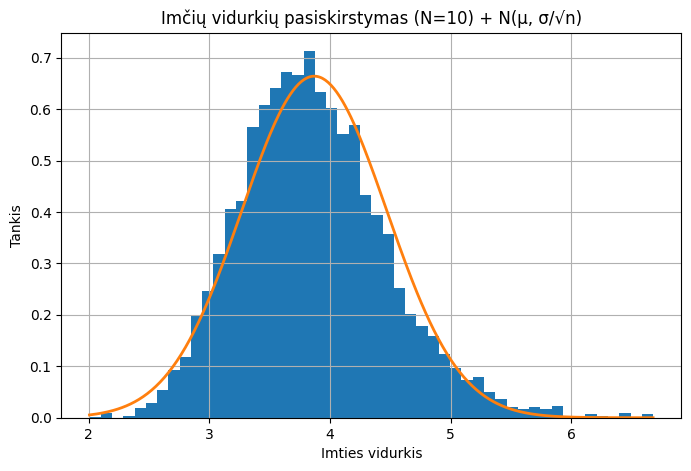

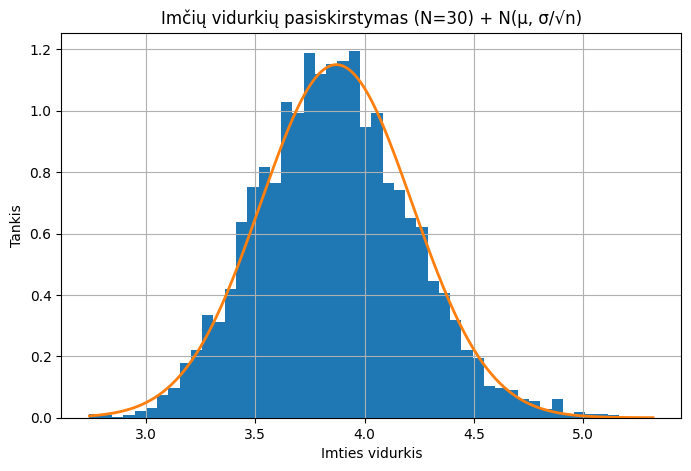

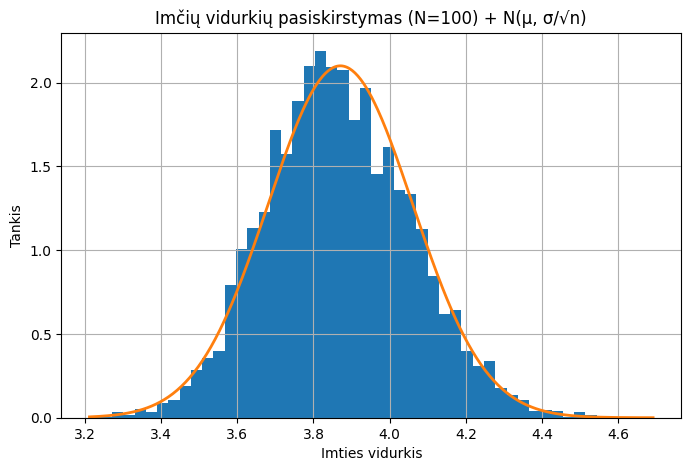

In [7]:

def sample_means(x, n=100, B=5000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    means = np.empty(B)
    N = x.size
    for b in range(B):
        idx = rng.integers(0, N, size=n)  # imame tikrus įrašus iš DF
        means[b] = x[idx].mean()
    return means

for N in [10, 30, 100]:
    means = sample_means(df["MedInc"].values, n=N, B=5000, seed=42)
    fig, ax = plt.subplots()
    ax.hist(means, bins=50, density=True)
    # Teorinis normalusis aproksimavimas N(μ, σ/√n)
    mu_hat = df["MedInc"].mean()
    sigma_hat = df["MedInc"].std(ddof=0) / np.sqrt(N)
    xs = np.linspace(means.min(), means.max(), 400)
    ax.plot(xs, stats.norm.pdf(xs, loc=mu_hat, scale=sigma_hat), linewidth=2)
    ax.set_title(f"Imčių vidurkių pasiskirstymas (N={N}) + N(μ, σ/√n)")
    ax.set_xlabel("Imties vidurkis"); ax.set_ylabel("Tankis")
    plt.show()


## 5. t‑test (Welch): ar `MedInc` skiriasi tarp dviejų geografinių grupių?

n1=10389, n2=10251
t=8.7010, p=0.000000
Interpretacija: jei p < 0.05 → statistiškai reikšmingas skirtumas.


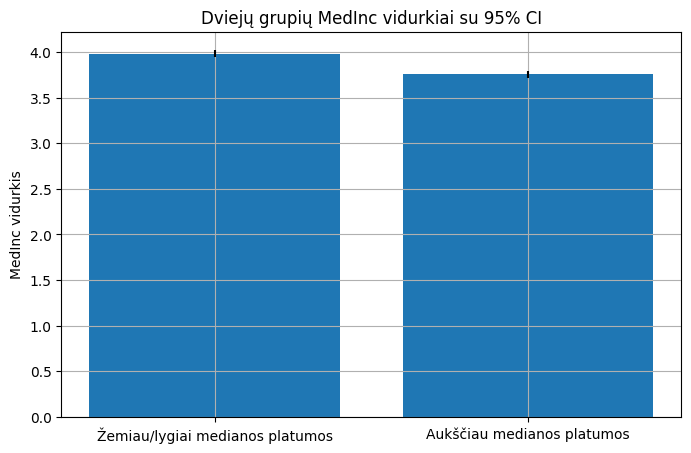

In [8]:

lat_med = df["Latitude"].median()
g1 = df.loc[df["Latitude"] <= lat_med, "MedInc"].values
g2 = df.loc[df["Latitude"] >  lat_med, "MedInc"].values

tstat, pval = stats.ttest_ind(g1, g2, equal_var=False)  # Welch
print(f"n1={len(g1)}, n2={len(g2)}")
print(f"t={tstat:.4f}, p={pval:.6f}")
print("Interpretacija: jei p < 0.05 → statistiškai reikšmingas skirtumas.")

# Vidurkiai su 95% CI vizualiai
def mean_ci(x, alpha=0.05):
    x = np.asarray(x); n = x.size
    xbar = x.mean(); s = x.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s / np.sqrt(n)
    return xbar, half

m1, e1 = mean_ci(g1); m2, e2 = mean_ci(g2)
fig, ax = plt.subplots()
ax.bar([0,1], [m1, m2], yerr=[e1, e2])
ax.set_xticks([0,1]); ax.set_xticklabels(["Žemiau/lygiai medianos platumos", "Aukščiau medianos platumos"])
ax.set_ylabel("MedInc vidurkis")
ax.set_title("Dviejų grupių MedInc vidurkiai su 95% CI")
plt.show()


## 6. Chi² testas (2×2): ar `MedInc` ir `MedHouseVal` nepriklausomi?

In [9]:

# Binarizuojame pagal medianas (tik iš tikro DF)
inc_high = (df["MedInc"] > df["MedInc"].median()).astype(int)
val_high = (df["MedHouseVal"] > df["MedHouseVal"].median()).astype(int)

table = pd.crosstab(inc_high, val_high)
display(table)

chi2, p, dof, expected = stats.chi2_contingency(table.values)
print(f"χ²={chi2:.3f}, df={dof}, p={p:.6f}")
print("Interpretacija: jei p < 0.05 → atmetame nepriklausomumą (galimas ryšys).")


MedHouseVal,0,1
MedInc,,
0,7659,2661
1,2664,7656


χ²=4833.341, df=1, p=0.000000
Interpretacija: jei p < 0.05 → atmetame nepriklausomumą (galimas ryšys).



## 7. Mini užduotys (TODO)
1. Apskaičiuokite **90% ir 99% CI** `MedInc` vidurkiui (pakeiskite `alpha`).
2. CLT dalyje pakeiskite `N` ir palyginkite histogramos formą.
3. t‑testui vietoj `Latitude` naudokite kitą pjūvį (pvz., `Longitude` medianą).
4. Chi² testui vietoj medianų naudokite **ketvirčius** (Q1/Q3) ir sudarykite 2×2 lentelę.


In [10]:

def ci_t_mean(x, alpha=0.1):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = x.size
    xbar = x.mean()
    s = x.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s / np.sqrt(n)
    return (xbar - half, xbar + half, xbar, s, n)

ci_lo, ci_hi, mean_medinc, s_medinc, n_medinc = ci_t_mean(df["MedInc"], alpha=0.1)
print(f"n = {n_medinc}")
print(f"Vidurkis = {mean_medinc:.6f}, s = {s_medinc:.6f}")
print(f"90% CI (t): [{ci_lo:.6f}, {ci_hi:.6f}]")

n = 20640
Vidurkis = 3.870671, s = 1.899822
90% CI (t): [3.848919, 3.892423]


In [12]:

def ci_t_mean(x, alpha=0.01):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = x.size
    xbar = x.mean()
    s = x.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s / np.sqrt(n)
    return (xbar - half, xbar + half, xbar, s, n)

ci_lo, ci_hi, mean_medinc, s_medinc, n_medinc = ci_t_mean(df["MedInc"], alpha=0.01)
print(f"n = {n_medinc}")
print(f"Vidurkis = {mean_medinc:.6f}, s = {s_medinc:.6f}")
print(f"99% CI (t): [{ci_lo:.6f}, {ci_hi:.6f}]")

n = 20640
Vidurkis = 3.870671, s = 1.899822
99% CI (t): [3.836605, 3.904737]


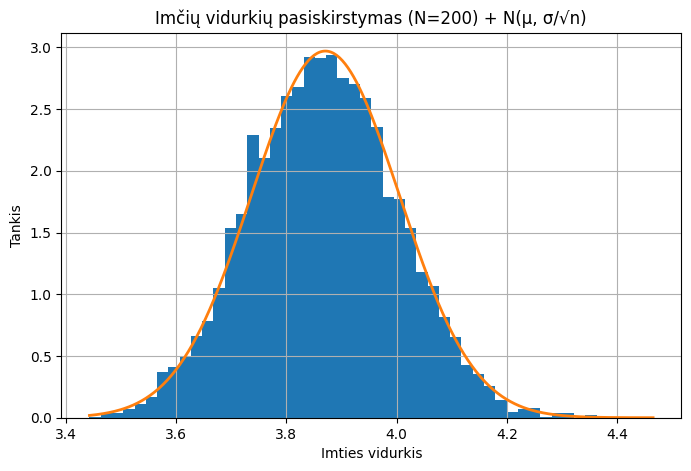

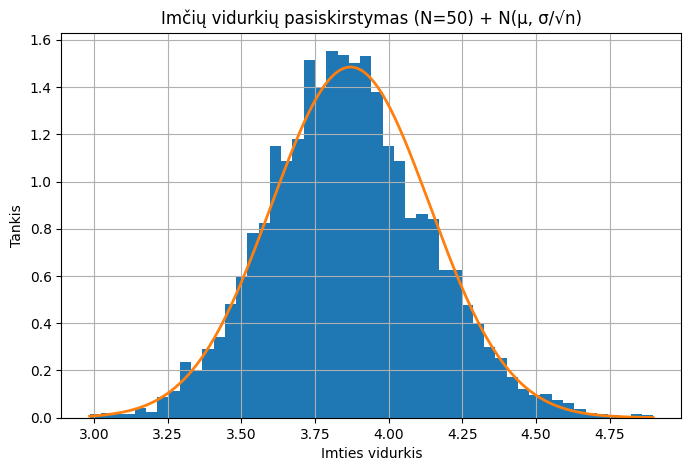

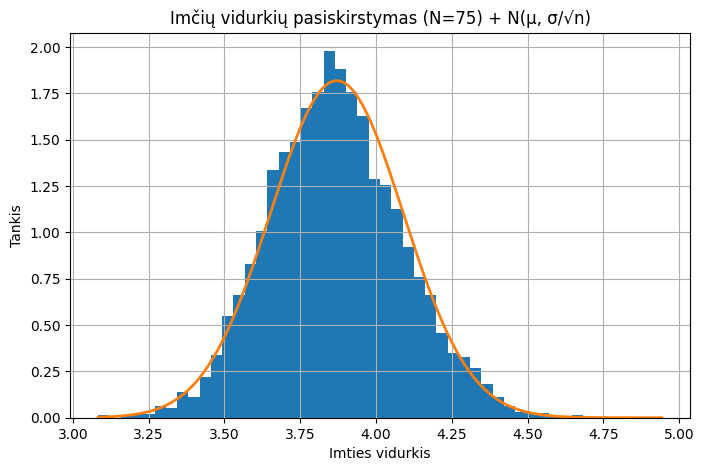

In [17]:

def sample_means(x, n=200, B=5000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    means = np.empty(B)
    N = x.size
    for b in range(B):
        idx = rng.integers(0, N, size=n)  # imame tikrus įrašus iš DF
        means[b] = x[idx].mean()
    return means

for N in [200, 50, 75]:
    means = sample_means(df["MedInc"].values, n=N, B=5000, seed=42)
    fig, ax = plt.subplots()
    ax.hist(means, bins=50, density=True)
    # Teorinis normalusis aproksimavimas N(μ, σ/√n)
    mu_hat = df["MedInc"].mean()
    sigma_hat = df["MedInc"].std(ddof=0) / np.sqrt(N)
    xs = np.linspace(means.min(), means.max(), 400)
    ax.plot(xs, stats.norm.pdf(xs, loc=mu_hat, scale=sigma_hat), linewidth=2)
    ax.set_title(f"Imčių vidurkių pasiskirstymas (N={N}) + N(μ, σ/√n)")
    ax.set_xlabel("Imties vidurkis"); ax.set_ylabel("Tankis")
    plt.show()

n1=10363, n2=10277
t=-1.0608, p=0.288781
Interpretacija: jei p < 0.05 → statistiškai reikšmingas skirtumas.


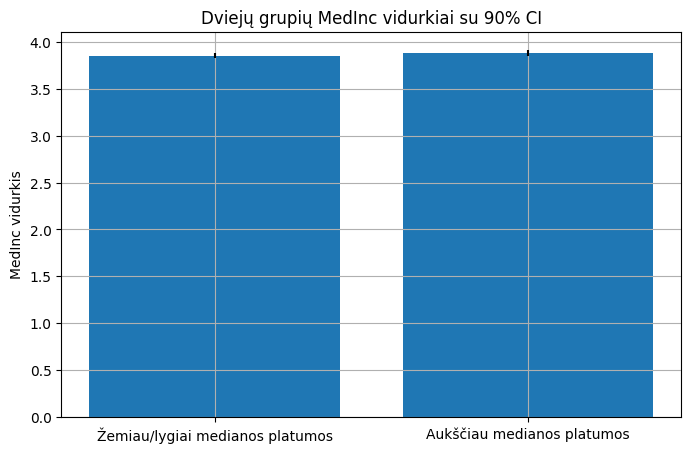

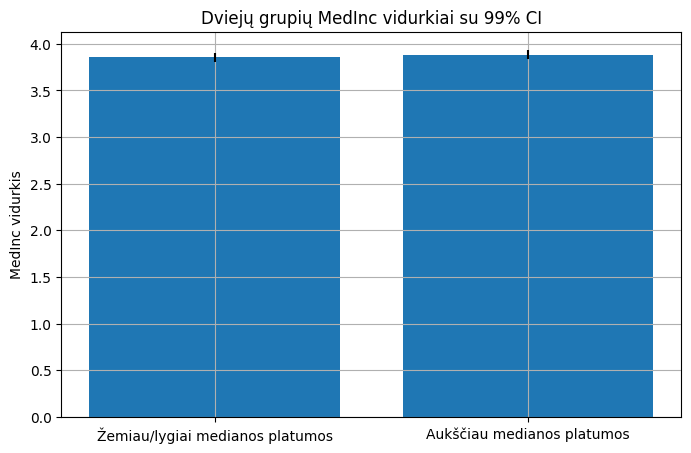

In [16]:
lat_med = df["Longitude"].median()
g1 = df.loc[df["Longitude"] <= lat_med, "MedInc"].values
g2 = df.loc[df["Longitude"] >  lat_med, "MedInc"].values

tstat, pval = stats.ttest_ind(g1, g2, equal_var=False)  # Welch
print(f"n1={len(g1)}, n2={len(g2)}")
print(f"t={tstat:.4f}, p={pval:.6f}")
print("Interpretacija: jei p < 0.05 → statistiškai reikšmingas skirtumas.")

# Vidurkiai su 90% CI vizualiai
def mean_ci(x, alpha=0.1):
    x = np.asarray(x); n = x.size
    xbar = x.mean(); s = x.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s / np.sqrt(n)
    return xbar, half

m1, e1 = mean_ci(g1); m2, e2 = mean_ci(g2)
fig, ax = plt.subplots()
ax.bar([0,1], [m1, m2], yerr=[e1, e2])
ax.set_xticks([0,1]); ax.set_xticklabels(["Žemiau/lygiai medianos platumos", "Aukščiau medianos platumos"])
ax.set_ylabel("MedInc vidurkis")
ax.set_title("Dviejų grupių MedInc vidurkiai su 90% CI")
plt.show()

# Vidurkiai su 99% CI vizualiai
def mean_ci(x, alpha=0.01):
    x = np.asarray(x); n = x.size
    xbar = x.mean(); s = x.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s / np.sqrt(n)
    return xbar, half

m1, e1 = mean_ci(g1); m2, e2 = mean_ci(g2)
fig, ax = plt.subplots()
ax.bar([0,1], [m1, m2], yerr=[e1, e2])
ax.set_xticks([0,1]); ax.set_xticklabels(["Žemiau/lygiai medianos platumos", "Aukščiau medianos platumos"])
ax.set_ylabel("MedInc vidurkis")
ax.set_title("Dviejų grupių MedInc vidurkiai su 99% CI")
plt.show()

In [18]:

# Binarizuojame pagal kvantilius (tik iš tikro DF)
inc_high = (df["MedInc"] > df["MedInc"].quantile()).astype(int)
val_high = (df["MedHouseVal"] > df["MedHouseVal"].quantile()).astype(int)

table = pd.crosstab(inc_high, val_high)
display(table)

chi2, p, dof, expected = stats.chi2_contingency(table.values)
print(f"χ²={chi2:.3f}, df={dof}, p={p:.6f}")
print("Interpretacija: jei p < 0.05 → atmetame nepriklausomumą (galimas ryšys).")

MedHouseVal,0,1
MedInc,,
0,7659,2661
1,2664,7656


χ²=4833.341, df=1, p=0.000000
Interpretacija: jei p < 0.05 → atmetame nepriklausomumą (galimas ryšys).
